### Determining horizon of within-subject correlations
In some individuals increase in cases might have immediate effect, in some it might be delayed 

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import pingouin as pg

from itertools import product
from scipy.stats import zscore as zscore_sc
from itertools import product, combinations


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))

##### VERY IMPORTANT ####
df["state_severity"] = df["deaths7_norm"]
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

tdf = df.loc[df["sess_str"]=="sess0",:]
tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]


#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
##df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]

##### VERY IMPORTANT ####

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'FutureThreatEsts',
           'q7_worry_econ_impact': 'EconWorry',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGroup',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaValence',
           'q7_period_rel_danger': 'DangerState',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'q6_houshold_membs': "HouseholdMembers",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }

df=df.rename(columns=mapdict)

# Create column with appropriate dates
df["Session"] = df["session"] + 1
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

## transform and generate some variables (to be moved to preprocessing)
special_vars = [
        # core things interested in 
        "DangerState",
        'InforSeek',
        "AvoidBeh",
        "Deaths"]
vars = [
        # core things interested in 
        "DangerState",
        "InforSeek",
        "AvoidBeh",
        "Deaths",

        # additional aspects potentially interested in 
        "AvoidAnx",
        "Worry", 
        "FutureThreatEsts",

        # environmental things that might be of interest             
        "Cases",
        "SocialDist", 
        "RiskGroup",
        "MediaValence", 
        "EconWorry",

        ]

# Zscore
for c in vars: 
    df[c] = df.groupby(by="Session")[c].apply(zscore_sc, nan_policy="omit")


### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
#print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 2
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==2:
        trait_factor_names = ["TF3", "TF2", "TF1"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

trait_df = df.groupby(by="PROLIFICID")[trait_factor_names].mean()

/data/drive/postdoc/Project4_covid


In [17]:
df.sr_age.dropna().astype(int).unique()



array([             32,              20,              21,              24,
                    23,              25,              18,              19,
                    33,              22,              35,              36,
                    34,              26,              40,              29,
                    30,              31,              28,              27,
                    41,              37,              38,              39,
       554025459000118,   5727863744427,             383,               4,
                     3])

### rearange data with window 4 sessions back 

In [51]:
win=4
def realign_win(x, win):
    nsess = 20
    x=x.reset_index(drop=True)
    y = np.zeros(shape=(nsess-win,win+1))*np.nan
    if x.shape[0] is 20:
        for w in range(win+1):
            y[:,w]= x["value"].iloc[w:nsess-win+w]
    else:
        x_interp = np.interp(np.arange(1,21), x["session"], x["value"])
        x = pd.DataFrame({"sess": np.arange(1,21), "value2":np.zeros((20))*np.nan}).set_index("sess").join(x.set_index("session"))
        x["value"] = x_interp
        x = x.reset_index()
        for w in range(win+1):
            y[:,w]= x["value"].iloc[w:nsess-win+w]
    v = x["variable"][0]
    cols = [v+"_lag"+str(w) for w in range(win, -1, -1)]
    return pd.DataFrame(y,columns=cols)

        
ttf = df.loc[:,vars+["session", "PROLIFICID"]].melt(id_vars=["PROLIFICID", "session"]).groupby(by=["PROLIFICID", "variable"]).apply(realign_win, win)
ttf = ttf.reset_index()#.pivot(index="PROLIFICID", columns=["lag2", "lag1", "lag0"])

In [52]:
ttf["PROLIFICID"].unique().shape

(300,)

In [53]:

# runs partial correlations with varying lag, controlling for all autocorrelations in dv and also all other iv lags 
# e.g. if dv(0) ~ iv(2) it will include iv0, iv1, iv3, and iv4 as covariates

combs = pd.DataFrame(list(product(vars, vars)), columns=['dv', 'iv'])
idx = np.array(combs["dv"] != combs["iv"])
combs = combs.loc[idx]
lagwin = 4


def get_partial_corrs(ttf, corr_type, combs, vars, lagwin):
    odf = pd.DataFrame()
    for iv, dv in zip(combs.iv, combs.dv): 
        dv_all = [dv+"_lag"+str(i) for i in range(lagwin+1) ] 
        iv_all = [iv+"_lag"+str(i) for i in range(lagwin+1) ] 
        qdf = pd.concat([ttf.loc[ttf["variable"]==dv,dv_all].reset_index(), ttf.loc[ttf["variable"]==iv,iv_all].reset_index()], axis=1).dropna()
        # DV covariate (account for autocorrelation in DV)
        dv_covar = [dv+"_lag"+str(i) for i in range(1,lagwin+1) ]
        Rs = []
        if qdf.shape[0] != 0:
            for wid in range(lagwin+1):
                iv_covar = list(set(iv_all) - set([iv+"_lag"+str(wid)]))
                c = pg.partial_corr(qdf, x=iv+"_lag"+str(wid), y=dv+"_lag0", covar=iv_covar+dv_covar, method=corr_type)
                Rs.append(float(c["r"]))
        else:
            [Rs.append(np.nan) for x in range(lagwin+1)]
        tedf = pd.DataFrame({"dv":[dv for i in range(lagwin+1)],
                             "iv":[iv for i in range(lagwin+1)], 
                             "lag": [i for i in range(lagwin+1)],  
                             "pcorr": Rs})
        odf = pd.concat([odf, tedf])
    #odf = odf.to_numpy(dtype='float', na_value=np.nan)   
    return(odf)

ld=1
if ld == 0:
    tdf = ttf.groupby(by="PROLIFICID").apply(get_partial_corrs, corr_type, combs, vars, lagwin)
    tdf = tdf.reset_index() 
    tdf.to_csv(os.path.join(root_dir, "output", "working_data", "lag0-4_partial_correlations.csv"))
else: 
    tdf = pd.read_csv(os.path.join(root_dir, "output", "working_data", "lag0-4_partial_correlations.csv"))

### get index of the highest predictiveness

PROBLEM: There are a lot of NaNs - need to check where they come from. 

In [54]:
def get_max(x):
    return np.nan if np.argmax(x["pcorr"])==-1 else np.argmax(x["pcorr"])

dfmax = tdf.groupby(by=["PROLIFICID", "dv", "iv"]).apply(get_max).reset_index().rename(columns={0:"idxmax"})
dfmax = dfmax.set_index("PROLIFICID").join(trait_df).reset_index()



<AxesSubplot:>

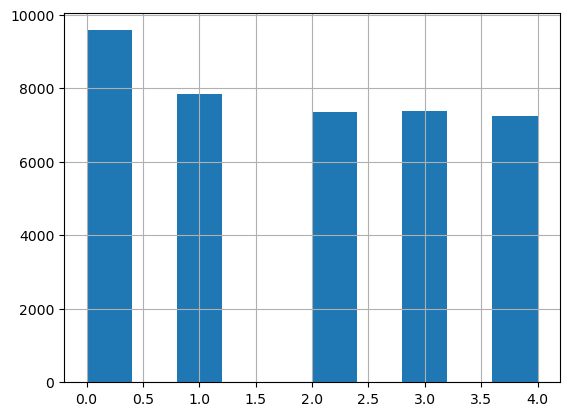

In [55]:
dfmax["idxmax"].hist()

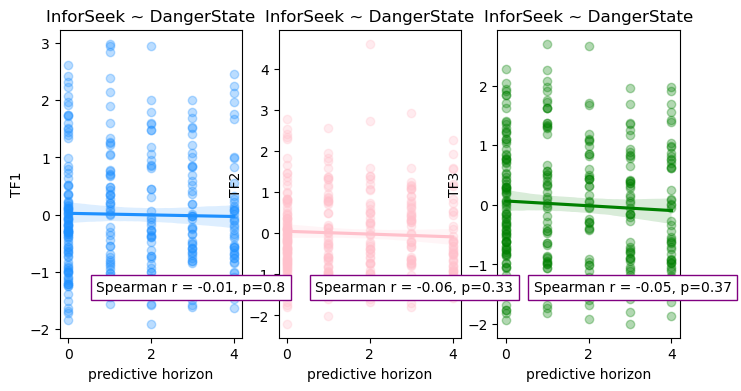

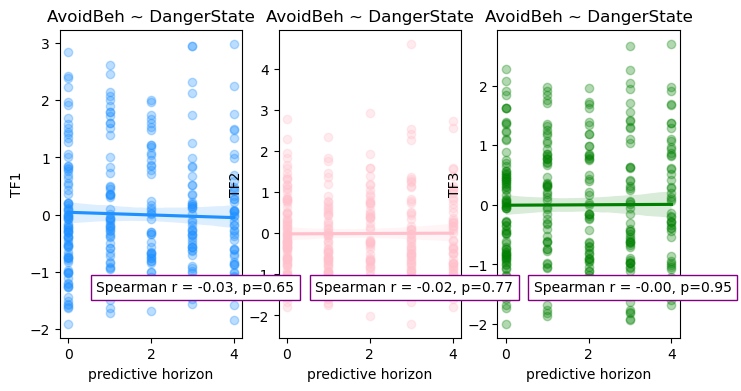

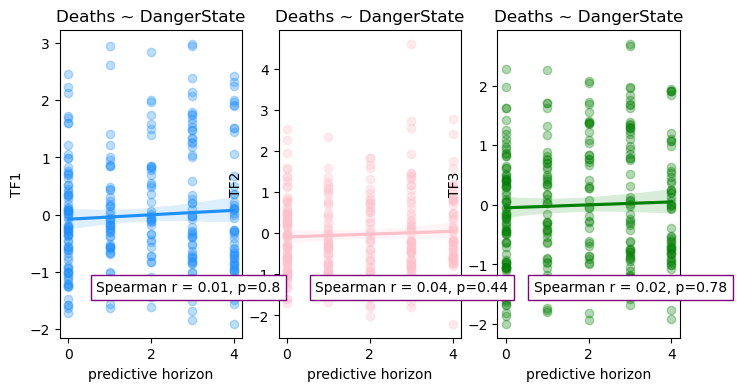

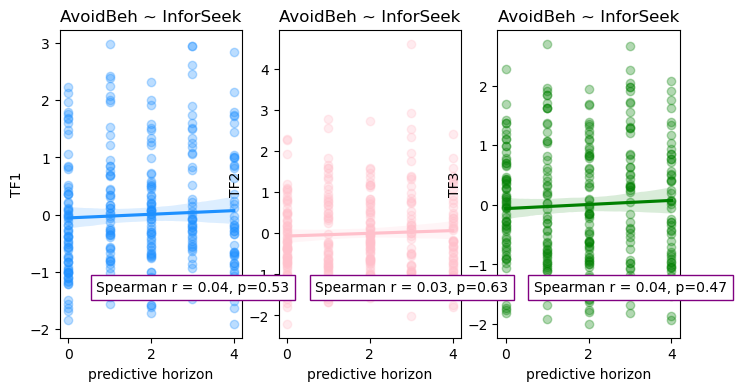

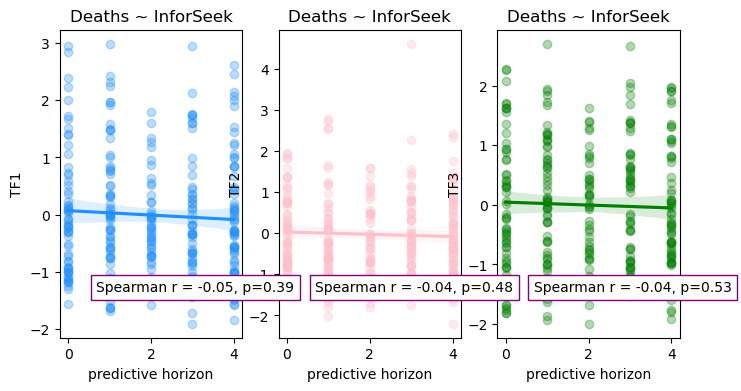

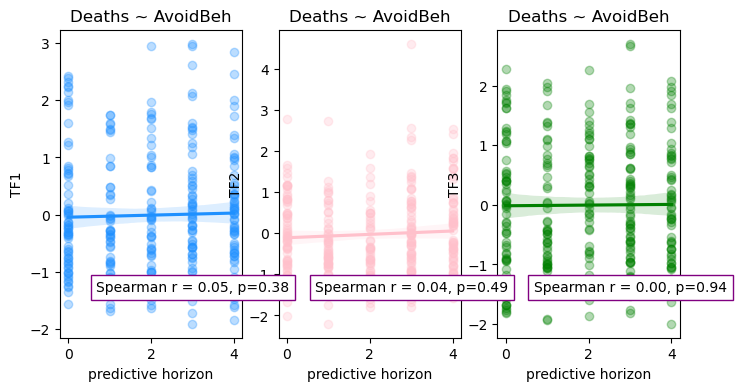

In [56]:

combs = pd.DataFrame(list(combinations(special_vars,2)), columns=["v1", "v2"])
pal = ["dodgerblue", "pink", "green"]
for v1, v2 in zip(combs.v1, combs.v2): 
    f, ax = plt.subplots(1,3,figsize=(8,4))
    dfmax2 = dfmax.loc[(dfmax["dv"].isin([v1])) & (dfmax["iv"].isin([v2])),:]
    for tridx,tr in enumerate(["TF1", "TF2", "TF3"]):
            axx =ax[tridx]
            axx= sns.regplot(data=dfmax2, x="idxmax", y=tr, ax=axx, line_kws={'color': pal[tridx]}, scatter_kws={'color':pal[tridx],'alpha':0.3})
            corrfunc(dfmax2[tr], dfmax2["idxmax"], drop_missing=True, tests=["spearman"], ax=axx, xanchor=0.2)
            axx.set_xlabel("predictive horizon")
            axx.set_title(v2+" ~ "+ v1)
            #ax[ttidx].set_ylabel("Change in "+v)
            #ax[ttidx].plot([min(maxs[tt]), max(maxs[tt])], [0,0], 'k--')

## For example: how do deaths predict perception of danger

In [57]:
dfmax   

PROLIFICID        dv                iv  idxmax       TF3  \
0      01S0stEpc3rU6YxK  AvoidAnx          AvoidBeh     0.0 -0.045855   
1      01S0stEpc3rU6YxK  AvoidAnx             Cases     0.0 -0.045855   
2      01S0stEpc3rU6YxK  AvoidAnx       DangerState     0.0 -0.045855   
3      01S0stEpc3rU6YxK  AvoidAnx            Deaths     1.0 -0.045855   
4      01S0stEpc3rU6YxK  AvoidAnx         EconWorry     3.0 -0.045855   
...                 ...       ...               ...     ...       ...   
39595  ztPVSoIVH3QKpGeQ     Worry  FutureThreatEsts     0.0 -1.471485   
39596  ztPVSoIVH3QKpGeQ     Worry         InforSeek     4.0 -1.471485   
39597  ztPVSoIVH3QKpGeQ     Worry      MediaValence     2.0 -1.471485   
39598  ztPVSoIVH3QKpGeQ     Worry         RiskGroup     4.0 -1.471485   
39599  ztPVSoIVH3QKpGeQ     Worry        SocialDist     2.0 -1.471485   

            TF2       TF1  
0     -0.573207  0.000099  
1     -0.573207  0.000099  
2     -0.573207  0.000099  
3     -0.573207  0.000099  
4     -0.573207  0.000099  
...         ...       ...  
39595  0.071957 -0.726433  
39596  0.071957 -0.726433  
39597  0.071957 -0.726433  
39598  0.071957 -0.726433  
39599  0.071957 -0.726433  

[39600 rows x 7 columns]

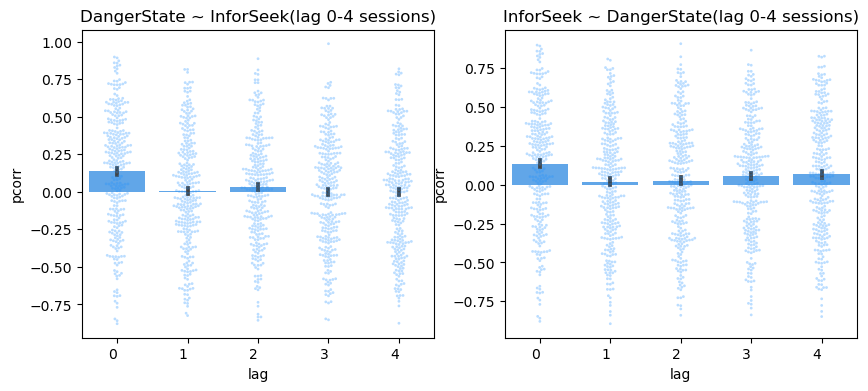

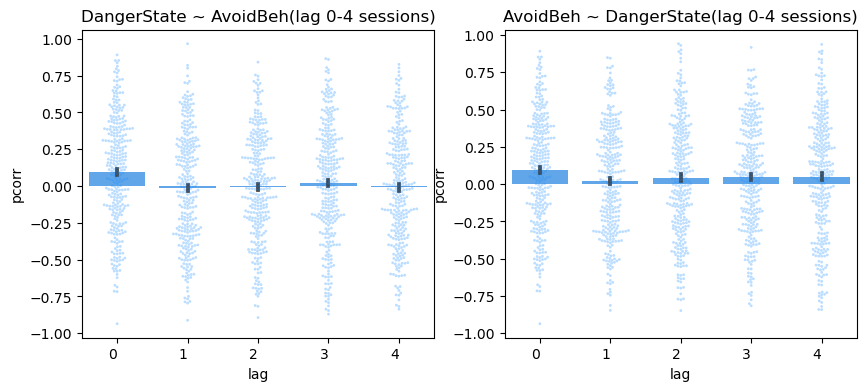

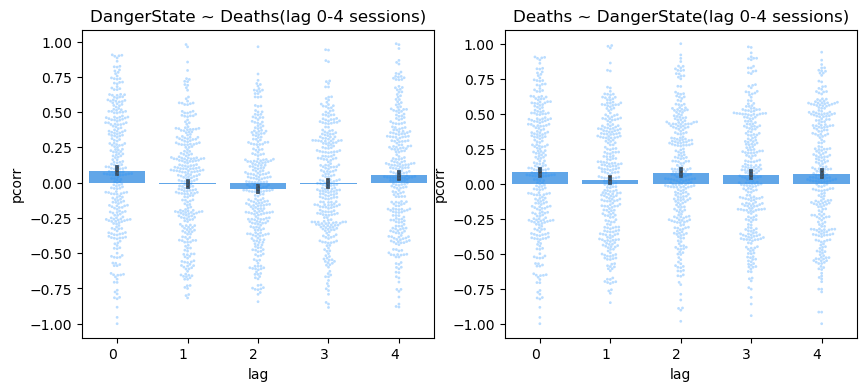

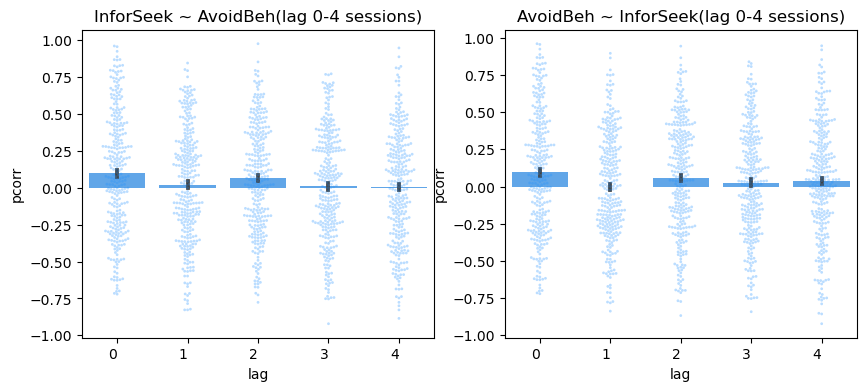

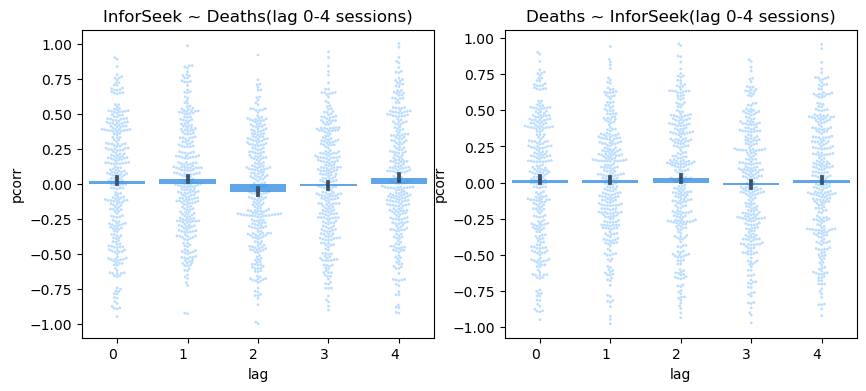

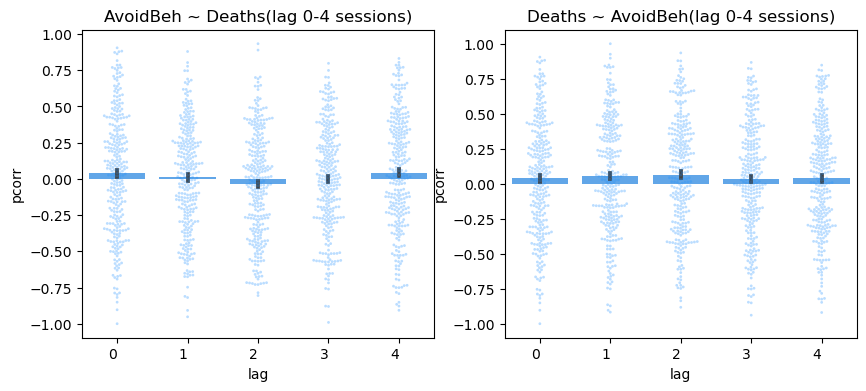

In [58]:
combs = pd.DataFrame(list(combinations(special_vars,2)), columns=["v1", "v2"])
for v1, v2 in zip(combs.v1, combs.v2): #zip(["Worry"], ["Probest"]): #
    f, ax = plt.subplots(1,2,figsize=(10, 4))
    ddf = tdf.loc[(tdf["dv"]==v1) & (tdf["iv"]==v2),:]
    pal = ["dodgerblue"]
    axx = ax[0]
    axx=sns.barplot(data=ddf, x="lag", y="pcorr", ci=68, ax=axx, palette=pal, alpha=0.8)
    axx=sns.swarmplot(data=ddf, x="lag", y="pcorr", size=2, ax=axx, palette=pal, dodge=False, color="black", alpha=0.3)
    axx.set_xticklabels(axx.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor'  )
    axx.set_title(v1+" ~ "+ v2 +"(lag 0-4 sessions)")
    axx.set_ylim

    ddf = tdf.loc[(tdf["dv"]==v2) & (tdf["iv"]==v1),:]
    pal = ["dodgerblue"]
    axx = ax[1]
    axx=sns.barplot(data=ddf, x="lag", y="pcorr", ci=68, ax=axx, palette=pal, alpha=0.8)
    axx=sns.swarmplot(data=ddf, x="lag", y="pcorr", size=2, ax=axx, palette=pal, dodge=False, color="black", alpha=0.3)
    axx.set_xticklabels(axx.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor'  )
    axx.set_title(v2+" ~ "+ v1 +"(lag 0-4 sessions)")
    axx.set_ylim